<a href="https://colab.research.google.com/github/cuongvng/neural-networks-with-PyTorch/blob/master/RNNs/PlainRNN/Plain_RNN.ipynb" target="_parent">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/>
</a>

In [4]:
!pip install git+https://github.com/cuongvng/neural-networks-with-PyTorch

  Cloning https://github.com/cuongvng/neural-networks-with-PyTorch to /tmp/pip-req-build-jw7utufh
  Running command git clone -q https://github.com/cuongvng/neural-networks-with-PyTorch /tmp/pip-req-build-jw7utufh
  Created wheel for train-plot-utils: filename=train_plot_utils-1.0-cp36-none-any.whl size=5563 sha256=6b555a20d9e213f49edc3810f2b958d420613341f760ed563528130aa04e502b
  Stored in directory: /tmp/pip-ephem-wheel-cache-66obv41y/wheels/f4/9e/b4/490959541c854701592541b5fc01eb4bf691e878c4496d3517
Successfully built train-plot-utils


Download time-series data

In [5]:
!curl https://raw.githubusercontent.com/cuongvng/neural-networks-with-PyTorch/master/RNNs/data/EURUSD.csv > EURUSD.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1864k  100 1864k    0     0  3329k      0 --:--:-- --:--:-- --:--:-- 3323k


In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import sys
sys.path.append("../..")
from utils.rnn_dataset_creator import ForexDataset
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu <class 'torch.device'>


Let see what the data looks like

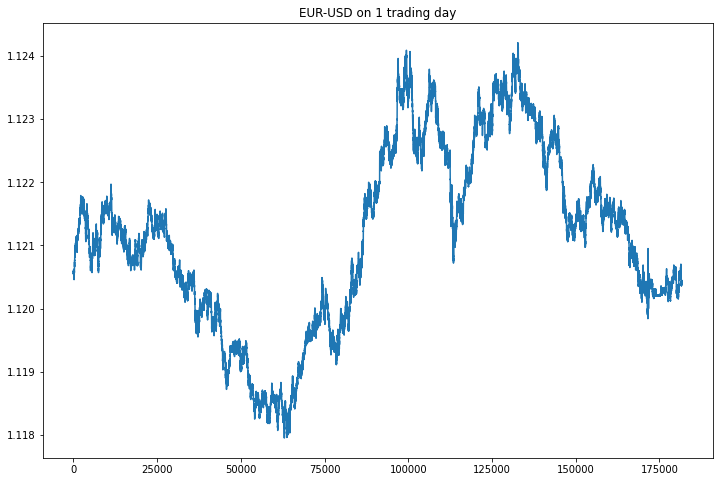

In [7]:
data = pd.read_csv("EURUSD.csv")
ax = data["Ask"].plot(figsize=(12,8), title="EUR-USD on 1 trading day")
plt.show()

Load data for training and testing by my custom PyTorch dataset class named `ForexDataset`. [Here](https://github.com/cuongvng/neural-networks-with-PyTorch/blob/rnn/utils/rnn_dataset_creator.py) is the source code of the class.

Each element in `data_train` and `data_test` is a tuple `(X, y)` in which `X` is a sequence of time-series data with length specified by `num_steps`, and `y` is the output of the sequence `X`, i.e., the next element in the series.

In [19]:
num_steps = 20
batch_size = 128

In [11]:
train_size = 0.8
data_train = ForexDataset(csv_file="EURUSD.csv", num_steps=num_steps, train=True, train_size=train_size)
data_test = ForexDataset(csv_file="EURUSD.csv", num_steps=num_steps, train=False, train_size=train_size)
print("Data train size:",len(data_train))
print("Data test size:", len(data_test))
print(data_train[0])

Data train size: 145414
Data test size: 36338
(tensor([1.1206, 1.1206, 1.1206, 1.1206, 1.1206, 1.1206, 1.1206, 1.1206, 1.1206,
        1.1206, 1.1206, 1.1206, 1.1206, 1.1206, 1.1206, 1.1206, 1.1206, 1.1206,
        1.1206, 1.1206], dtype=torch.float64), tensor(1.1206, dtype=torch.float64))


Create data iterators for the custom dataset by `torch.utils.data.DataLoader`




In [12]:
train_loader = DataLoader(dataset=data_train, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(dataset=data_test, batch_size=batch_size, shuffle=False, num_workers=4)

Now let take a revision on RNN with hidden state

<figure>
    <center>
        <img src="https://github.com/cuongvng/neural-networks-with-PyTorch/blob/master/RNNs/img/rnn.svg?raw=1" width=75%></img>
        <figcaption> Computational flow of RNN </figcaption>  
    </center>
</figure>

As we can see, an RNN block at timestep $t$ take both the current input $X_t$ and the previous hidden state $H_{t-1}$ as its input. The block then outputs its current hidden state $H_t$ and and output value $O_t$. Those are calculated via

$$
H_t = \phi(X_{t-1}*W_{xh} + H_{t-1}*W_{hh} + b_h)
$$

Here $W_{xh} \in R^{d \times h}$ and $W_{hh} \in R^{h \times h}$ are the weight parameters corresponding to the input and the previous hidden state, respectively. $b_h \in R^h$ is the bias. 

$d$ is the number of features of the data at each timestep, while $h$ is the number of hidden units (it is a tunable hyperparameter). In our case, $X_t$ has the shape of `(num_steps, 1)`, which means $d=1$.

The result of the linear operation will be passed through an activation function $\phi$.

After obtaining $H_t$, the output at the current timestep $O_t$ is determined by

$$
O_t = H_t*W_{ho} + b_o
$$

with $W_{ho} \in R^{h \times o}$ and $b_o \in R^o$. In our time-series problem, we are going to predict the next forex rate given a sequence of previous rate, so $o=1$.

Now let's implement RNN model **from scratch**

In [33]:
class RNN_scratch(object):
    def __init__(self, batch_size, num_hidden, n_features, device):
        self.num_hidden = num_hidden
        self.n_features = n_features
        self.batch_size = batch_size
        self.device = device
        self.init_state = self.init_state()
        self.params = self.get_params()

    def __call__(self, inputs, state):
        return self.forward(inputs, state)
    
    def get_params(self):
        d = self.n_features
        o = self.n_features
        h = self.num_hidden
        device = self.device
        print(device, type(device))
        W_xh = torch.randn(size=(d, h), requires_grad=True, device=device)
        W_hh = torch.randn(size=(h, h), requires_grad=True, device=device)
        b_h = torch.randn(size=(h,), requires_grad=True, device=device)
        W_ho = torch.randn(size=(h, o), requires_grad=True, device=device)
        b_o = torch.randn(size=(o,), requires_grad=True, device=device)

        return (W_xh, W_hh, b_h, W_ho, b_o)

    def init_state(self):
        return torch.zeros(size=(self.batch_size, self.num_hidden), device=self.device)

    def forward(self, inputs, state):
        # Input shape: (batch_size, num_steps, n_features=1)
        W_xh, W_hh, b_h, W_ho, b_o = self.params
        outputs = []
        H = state
        for X in inputs:
            H = F.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)
            O = torch.mm(H, W_ho) + b_o
            outputs.append(O)
        outputs = torch.cat(torch.tensor(outputs, dim=0))
        
        return outputs, H

In [34]:
# A sanity check
inputs = torch.randn(size=(batch_size, num_steps, 1))
rnn = RNN_scratch(batch_size=batch_size, num_hidden=128, n_features=1, device=device)
outputs, final_state = rnn(inputs, rnn.init_state)
print(outputs.shape)
print(final_state.shape)

cpu <class 'torch.device'>


RuntimeError: ignored